# <font color=green>ADD-Net: An Effective Deep Learning Model for Early Detection of Alzheimer’s Diseases in MRI Scans</font>

### <font color=orange> Installs </font>

pip install tensorflow

pip install keras

pip install imblearn

pip install matplotlib

pip install seaborn

pip install scikit-learn

pip install tensorflow-addons

### <font color=orange> Importing Libraries </font>

In [28]:
import numpy as np
import random

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

# loading previous models
from tensorflow.keras.models import load_model

#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

#   SMOTETomek from imblance library
from imblearn.combine import SMOTETomek

#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle

### <font color=orange> Define directory of dataset & Classes names </font>

In [29]:
## Set Path Here before running the code
train_path = 'C:\\Users\\pedro\\Project\\Datasets\\ADNI\\train'
val_path = 'C:\\Users\\pedro\\Project\\Datasets\\ADNI\\val'
test_path = 'C:\\Users\\pedro\\Project\\Datasets\\ADNI\\test'

##  Name of classes 
CLASSES = ['AD','CN','EMCI', 'LMCI','MCI']

### <font color=orange> ImageDataGenerator: Rescale and Splitting dataset for Training, Validation and Testing (70/30/30) </font>

In [30]:
# Rescale images
datagen = ImageDataGenerator(rescale=1./255) 

train_generator = datagen.flow_from_directory(
    train_path, 
    target_size=(176, 208),
    batch_size=32,    # Set the batch size according to your system memory
    shuffle=True,
    class_mode='categorical')  # set as training data

validation_generator = datagen.flow_from_directory(
    val_path, 
    target_size=(176, 208),
    batch_size=32,   # Set the batch size according to your system memory
    shuffle=True,
    class_mode='categorical')  # set as validation data

test_generator = datagen.flow_from_directory(
    test_path,  
    target_size=(176, 208),
    batch_size=32,   # Set the batch size according to your system memory
    shuffle=False,   # Usually you should not shuffle test set
    class_mode='categorical')  # set as test data

Found 37576 images belonging to 5 classes.
Found 8051 images belonging to 5 classes.
Found 8053 images belonging to 5 classes.


In [33]:
def get_samples_per_class(generator):
    # Get class labels to class indices mapping
    class_indices = generator.class_indices

    # Reverse this dictionary, to get indices to class name mapping
    indices_to_class = {v: k for k, v in class_indices.items()}

    # Count occurrences of each label in the generator.classes list
    unique, counts = np.unique(generator.classes, return_counts=True)

    # Prepare class name and corresponding count
    count_dict = {indices_to_class[u]: count for u, count in zip(unique, counts)}
    
    return count_dict

# For each set
train_counts = get_samples_per_class(train_generator)
val_counts = get_samples_per_class(validation_generator)
test_counts = get_samples_per_class(test_generator)

# Get all unique class names from the three sets
all_classes = set(train_counts.keys()).union(val_counts.keys()).union(test_counts.keys())

# Print in columns
print(f'{"Class":<20}{"Train":<10}{"Val":<10}{"Test":<10}')
for class_name in all_classes:
    train_count = train_counts.get(class_name, 0)
    val_count = val_counts.get(class_name, 0)
    test_count = test_counts.get(class_name, 0)
    print(f'{class_name:<20}{train_count:<10}{val_count:<10}{test_count:<10}')


Class               Train     Val       Test      
CN                  10633     2278      2279      
AD                  5019      1075      1076      
LMCI                4452      954       954       
MCI                 8918      1911      1911      
EMCI                8554      1833      1833      


### <font color=orange> Show some random samples from the original dataset </font>

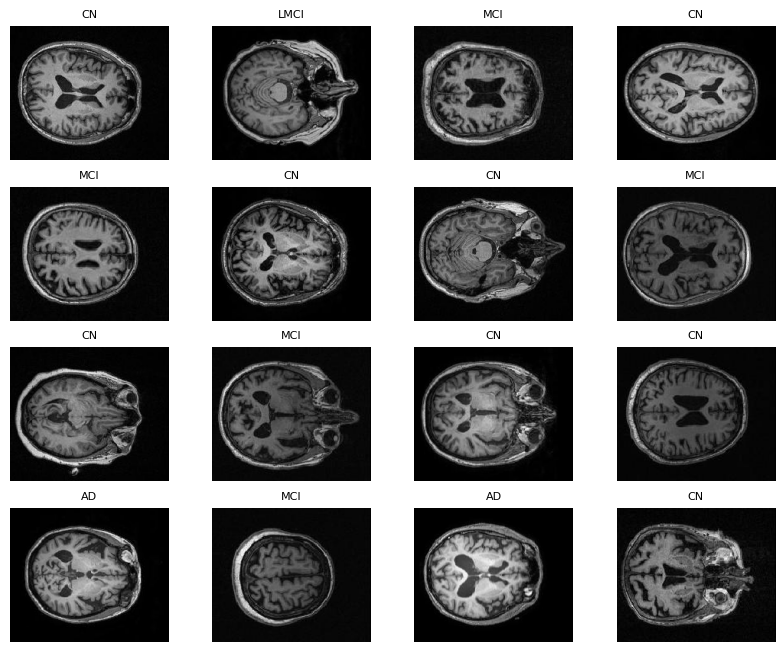

In [34]:
# Get a single batch of images
X_batch, y_batch = next(train_generator)

# Plot the images
fig = plt.figure(figsize=(10, 8))
rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(X_batch[i])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y_batch[i]))], fontsize=8)

plt.axis('off')
plt.show()

### <font color=orange> Model Architecture </font>

In [35]:
from keras.initializers import GlorotUniformV2
init = GlorotUniformV2

model = Sequential()

model.add(Input(shape=(176, 208, 3)))

model.add(Convolution2D(16, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(32, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Convolution2D(128, 5, kernel_initializer=init))
model.add(ReLU())
model.add(AveragePooling2D(pool_size=(2,2)))


model.add(Dropout(0.01))

model.add(Flatten())

model.add(Dense(256, kernel_initializer=init))
model.add(ReLU())
model.add(Dropout(0.03))

model.add(Dense(5, kernel_initializer=init))
model.add(Softmax())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 172, 204, 16)      1216      
                                                                 
 re_lu (ReLU)                (None, 172, 204, 16)      0         
                                                                 
 average_pooling2d (AverageP  (None, 86, 102, 16)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 98, 32)        12832     
                                                                 
 re_lu_1 (ReLU)              (None, 82, 98, 32)        0         
                                                                 
 average_pooling2d_1 (Averag  (None, 41, 49, 32)       0         
 ePooling2D)                                            

### <font color=orange> Compiling the Model </font>

In [36]:
### Model Compilation
model.compile(
    optimizer=SGD(learning_rate=0.01), 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=5),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> Defining CALLBACKS to reduce Learning Rate </font>

In [37]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

### <font color=orange> Training of the Model </font>

In [38]:
#   defining batch size
batch_size = 32

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 40)

Epoch 1/40
1174/1174 [==============================] - 802s 682ms/step - loss: 1.4061 - acc: 0.3807 - auc: 0.7189 - f1_score: 0.2782 - precision: 0.5353 - recall: 0.0750 - val_loss: 1.3190 - val_acc: 0.4275 - val_auc: 0.7599 - val_f1_score: 0.2935 - val_precision: 0.5462 - val_recall: 0.1728
Epoch 2/40
1174/1174 [==============================] - 713s 608ms/step - loss: 1.2533 - acc: 0.4417 - auc: 0.7840 - f1_score: 0.3493 - precision: 0.5717 - recall: 0.1806 - val_loss: 1.2065 - val_acc: 0.4702 - val_auc: 0.8072 - val_f1_score: 0.3718 - val_precision: 0.6351 - val_recall: 0.1460
Epoch 3/40
1174/1174 [==============================] - 731s 623ms/step - loss: 1.1679 - acc: 0.4878 - auc: 0.8156 - f1_score: 0.4181 - precision: 0.6137 - recall: 0.2527 - val_loss: 1.1299 - val_acc: 0.5128 - val_auc: 0.8292 - val_f1_score: 0.4475 - val_precision: 0.6449 - val_recall: 0.2688
Epoch 4/40
1174/1174 [==============================] - 963s 820ms/step - loss: 1.0598 - acc: 0.5491 - auc: 0.8516 - f

### <font color=orange> Hyperparameter tuning </font>

### <font color=orange> Evaluation of Model with the Test data </font>

In [39]:
# Evaluate the model on the test data
test_scores = model.evaluate(test_generator)

print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

252/252 [==============================] - 69s 274ms/step - loss: 0.3087 - acc: 0.9464 - auc: 0.9865 - f1_score: 0.9421 - precision: 0.9475 - recall: 0.9451


Testing Loss : 		 0.308741
Testing Accuracy : 	 94.635540 %
Testing AC : 		 98.654014 %
Testing F1-Score : 	 93.603826 %
Testing Precision : 	 94.746667 %
Testing Recall : 	 94.511360 %


### <font color=orange> Model Training graphs </font>
- Accuracy
- Loss
- AUC
- Precision
- Recall
- F1-Score

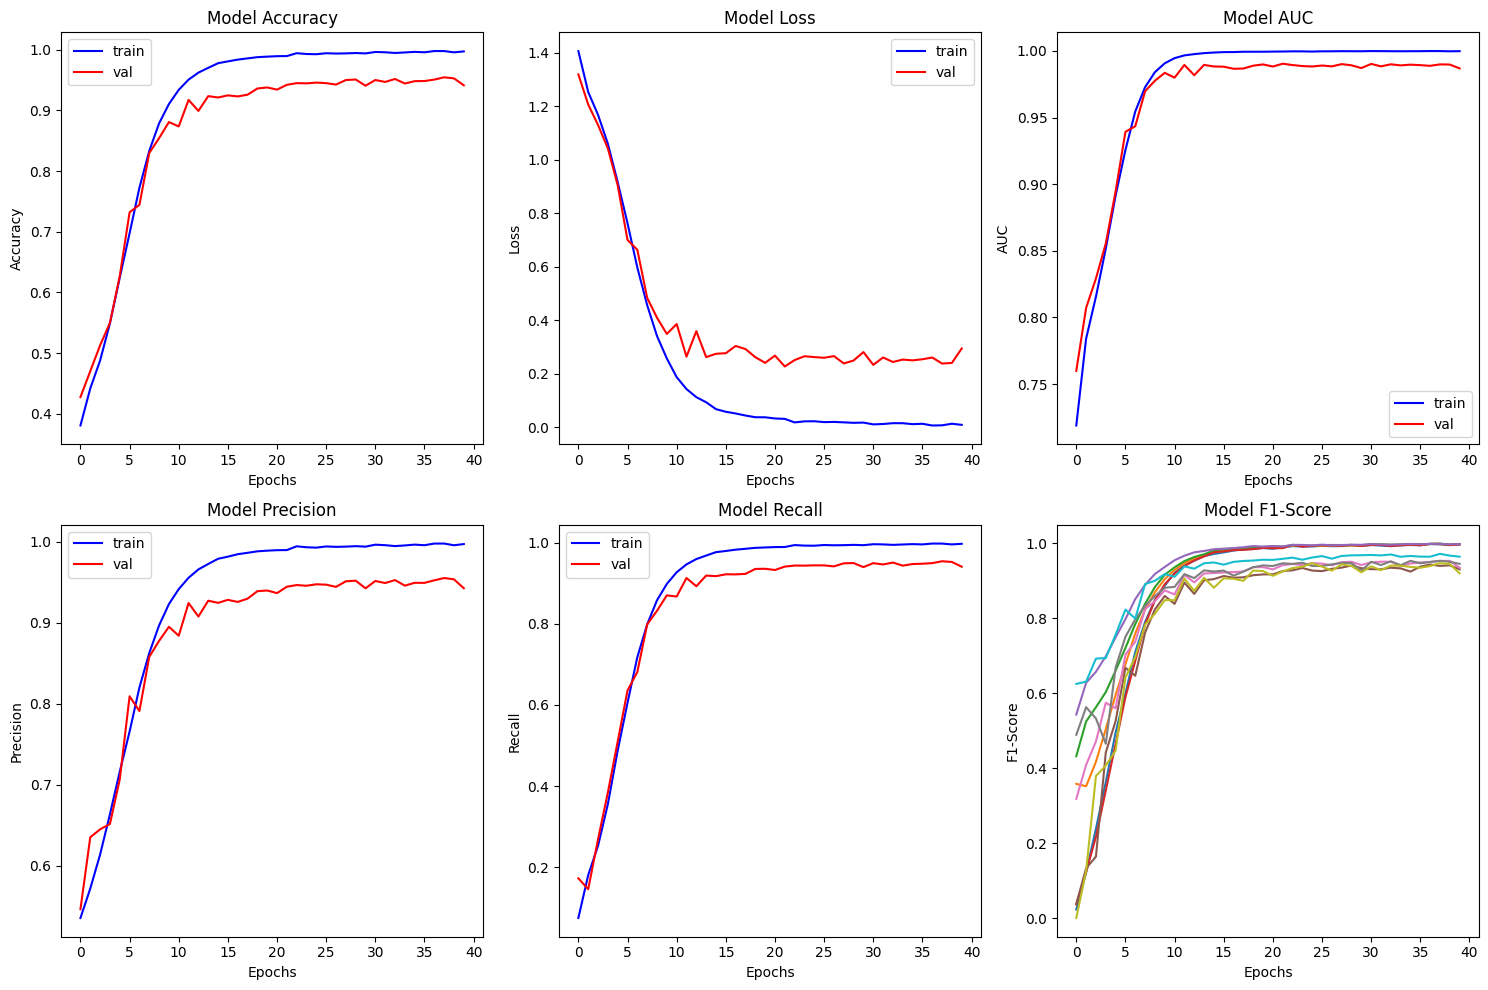

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot Accuracy
axes[0, 0].plot(history.history['acc'], 'b')
axes[0, 0].plot(history.history['val_acc'], 'r')
axes[0, 0].set_title("Model Accuracy")
axes[0, 0].set_xlabel("Epochs")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].legend(["train", "val"])

# Plot Loss
axes[0, 1].plot(history.history['loss'], 'b')
axes[0, 1].plot(history.history['val_loss'], 'r')
axes[0, 1].set_title("Model Loss")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend(["train", "val"])

# Plot AUC
axes[0, 2].plot(history.history['auc'], 'b')
axes[0, 2].plot(history.history['val_auc'], 'r')
axes[0, 2].set_title("Model AUC")
axes[0, 2].set_xlabel("Epochs")
axes[0, 2].set_ylabel("AUC")
axes[0, 2].legend(["train", "val"])

# Plot Precision
axes[1, 0].plot(history.history['precision'], 'b')
axes[1, 0].plot(history.history['val_precision'], 'r')
axes[1, 0].set_title("Model Precision")
axes[1, 0].set_xlabel("Epochs")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].legend(["train", "val"])

# Plot Recall
axes[1, 1].plot(history.history['recall'], 'b')
axes[1, 1].plot(history.history['val_recall'], 'r')
axes[1, 1].set_title("Model Recall")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Recall")
axes[1, 1].legend(["train", "val"])

# Plot F1-Score
axes[1, 2].plot(history.history['f1_score'])
axes[1, 2].plot(history.history['val_f1_score'])
axes[1, 2].set_title("Model F1-Score")
axes[1, 2].set_xlabel("Epochs")
axes[1, 2].set_ylabel("F1-Score")

# Ensure the plot is displayed properly with all the subplots visible.
fig.tight_layout()

plt.show()


### <font color=orange> Test set Evaluation </font>
- Classification Report
- Confusion Matrix
- ROC Curve
- Extension ROC Multiclass

In [41]:
# Generate predictions
pred_probabilities = model.predict(test_generator)
pred_labels = np.argmax(pred_probabilities, axis=-1)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for prob in pred_probabilities:
    labels = roundoff(prob)

# Get the true labels
true_labels = test_generator.classes

# Get the class label names
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_labels, pred_labels, target_names=class_labels))


252/252 [==============================] - 31s 123ms/step
              precision    recall  f1-score   support

          AD       0.94      0.91      0.92      1076
          CN       0.92      0.97      0.94      2279
        EMCI       0.96      0.95      0.95      1833
        LMCI       0.95      0.90      0.92       954
         MCI       0.97      0.96      0.97      1911

    accuracy                           0.95      8053
   macro avg       0.95      0.94      0.94      8053
weighted avg       0.95      0.95      0.95      8053



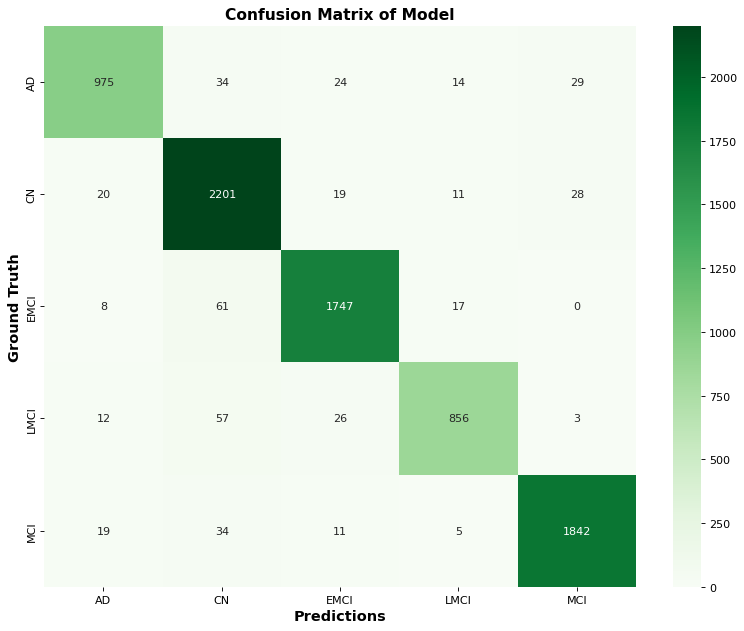

In [42]:
pred_ls = pred_labels
true_ls = true_labels

conf_arr = confusion_matrix(true_ls, pred_ls)
plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= class_labels, yticklabels= class_labels)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

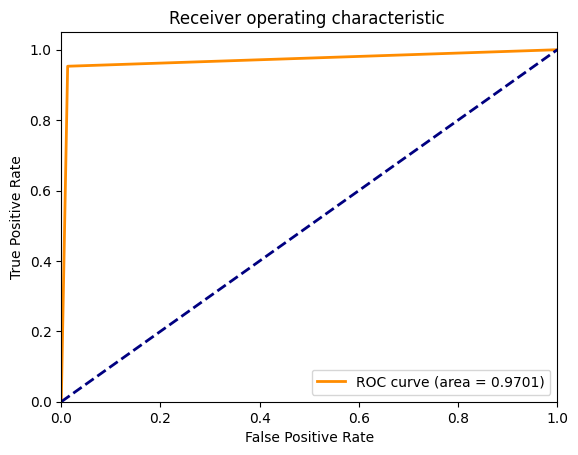

In [43]:
n_classes=5
# For ROC curve, we need the probabilities instead of the predicted labels
pred_probabilities = pred_probabilities

# Now y_test should be one-hot encoded, not categorical
y_test_bin = tf.keras.utils.to_categorical(true_ls, num_classes=n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

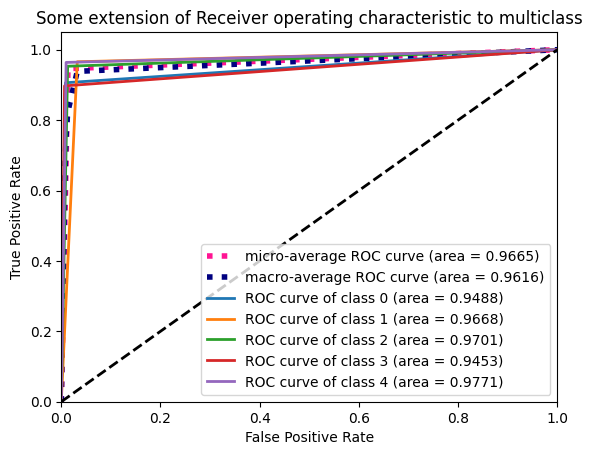

In [44]:
n_classes = 5
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### <font color=orange> Layer activation visualization </font>

In [45]:
from tensorflow.keras.models import Model

def visualize_class_activation(model, input_image, layer_name):
    # Create a model that will return these output layers given the model's input
    layer_output = model.get_layer(layer_name).output
    intermediate_model = Model(inputs=model.input, outputs=layer_output)
    intermediate_output = intermediate_model.predict(input_image)

    # We'll only visualize the first channel of the activations
    first_channel_activation = intermediate_output[0, :, :, 0]

    # Normalize to range between 0 and 1
    first_channel_activation -= first_channel_activation.mean()
    first_channel_activation /= first_channel_activation.std()
    first_channel_activation *= 64
    first_channel_activation += 128
    first_channel_activation = np.clip(first_channel_activation, 0, 255).astype('uint8')

    return first_channel_activation


1/1 [==============================] - 0s 45ms/step


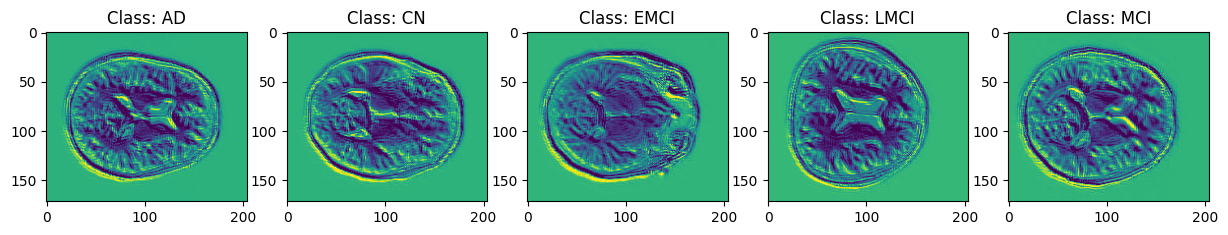

In [47]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(image_path):
    image = load_img(image_path, target_size=(176, 208))
    image = img_to_array(image)
    image = image/255.0  # If your model expects normalized input
    image = np.expand_dims(image, axis=0)
    return image

# Define paths to representative images for each class
image_paths = {
    "AD": "C:/Users/pedro/Project/Datasets/ADNI/test/AD/slices_ADNI_002_S_1018_MR_MPRAGE_br_raw_20071208022809184_1_S43496_I84444.nii_01.jpg",
    "CN": "C:/Users/pedro/Project/Datasets/ADNI/test/CN/slices_ADNI_002_S_0413_MR_MPRAGE_br_raw_20090430233743396_1_S66926_I142972.nii_01.jpg",
    "EMCI": "C:/Users/pedro/Project/Datasets/ADNI/test/EMCI/slices_ADNI_002_S_2010_MR_MPRAGE_br_raw_20110708102746110_70_S114024_I243872.nii_02.jpg",
    "LMCI": "C:/Users/pedro/Project/Datasets/ADNI/test/LMCI/slices_ADNI_002_S_4171_MR_MPRAGE_br_raw_20110809145004686_85_S118013_I249535.nii_10.jpg",
    "MCI": "C:/Users/pedro/Project/Datasets/ADNI/test/MCI/slices_ADNI_002_S_1070_MR_MPRAGE_br_raw_20070608171554842_1_S33353_I56588.nii_10.jpg",
}

# Choose a layer to visualize
layer_name = 'conv2d'

# Create a figure to hold the plots
fig = plt.figure(figsize=(15, 15))

for i, (class_name, image_path) in enumerate(image_paths.items()):
    image = load_and_preprocess_image(image_path)
    fig.add_subplot(1, len(image_paths), i+1)
    plt.title(f'Class: {class_name}')
    plt.imshow(visualize_class_activation(model, image, layer_name))

plt.show()


### <font color=orange> Saving Model for Future Use </font>

In [46]:
#    To save the model in the current directory
model.save("C:\\Users\\pedro\\Project\\Assets\\ADDNet\\ADNI\\Models\\ADDmodel4_ADNI.h5")